In [40]:
#Import all package
from qutip import basis, sigmax, sigmaz, sigmay, Options 
from qutip.solver.heom import DrudeLorentzBath
from qutip.solver.heom import HEOMSolver
from qutip.solver.heom import DrudeLorentzPadeBath
from qutip.solver.heom import BathExponent
import math
__all__ = ['parallel_map', 'serial_map', 'loky_pmap', 'mpi_pmap']

import multiprocessing
import os
import sys
import time
import threading
import concurrent.futures
import warnings
from qutip.ui.progressbar import progress_bars
from qutip.settings import available_cpu_count
from scipy.fft import fft, ifft 
from scipy.special import shichi
from mpmath import meijerg

import matplotlib.pyplot as plt
import qutip

import numpy as np 
import time 




# More flexibel solver for custom bath
from qutip.solver.heom import HSolverDL
from qutip.solver.heom import BosonicBath

import qutip.solver.brmesolve as brmesolve
print("no import errors")

no import errors


In [41]:
#Define the parameters
#Grösstes Problem bei grösserem TD wird der Realteil grösser. Im realteil steckt die Temperature. 
#Also muss die matsubara zahl erhöht werden.
#System parameters
#kb=1
#hbar=1
w0 = np.float128(1) # Alle frequenzen in einheiten der resonanzfrequenz. 
g = 0.02 # coupling strengt in omega 
#Bath
T=np.float128(0.05) # Bath Temperature in Units of hb*omega / kb
beta=1/T
#Td=0.4 war spannend mit  temp 0.01 und gamma=2 
Td=np.float128(0.24)  # Telaytime in w0⁻1
#Spectral density parameters
lam =np.float128(g**2)
gamma =np.float128(5) #cut-off frequency in einheiten  von omega. Steigt mit temperatur. amplitude der noise spielt auch eine rolle 

#Number of Matsubrafrequencies
Nk=80
#Deepnes of the hirarchay 
Ndepth=10


In [42]:
#Defina all operators and Hamiltonion 
P11=basis(2,0)*basis(2,0).dag()
P22=basis(2,1)*basis(2,1).dag()
P12=basis(2,0)*basis(2,1).dag()
P21=basis(2,1)*basis(2,0).dag()


H_sys=0.5*w0*sigmaz()#System hamilton




Q=(P12+P21) #Interaction term on system side

tmax=1.5
tlist = np.linspace(0,tmax, 100000)


# Initial state of the system:
rho0 = P22

In [44]:
#Matsubara zerlegung bad mit drude lorez spektraldichte mal cos(Td*w/2)^2 
def cot(x):
    return 1. / np.tan(x)


# C_real expansion terms:
ck_real = [(-lam * gamma *(np.cosh(gamma * Td/2)**2)*cot(beta*gamma/2))]
ck_real.extend([(-4*n*np.pi*T**2*gamma*lam*np.cosh((n*np.pi*T*Td)/1)**2)/(4*n**2*np.pi**2*T**2 - 1**2*gamma**2)
    for n in range(1, Nk + 1)
])
vk_real = [gamma]
vk_real.extend([2 * np.pi * n * T for n in range(1, Nk + 1)])

# C_imag expansion terms (this is the full expansion):
ck_imag = [(-1j)*gamma*lam*np.cosh((gamma*Td)/2)**2]
vk_imag = [gamma]
Bad=BosonicBath(Q, ck_real, vk_real, ck_imag, vk_imag)
print(ck_real)

[0.010337069661869077373, 2.5268232367277396157e-06, 5.1362868109835885756e-06, 7.918007558046241365e-06, 1.0976791802011569656e-05, 1.4443711300058679175e-05, 1.8492645936335325164e-05, 2.3367007206883431916e-05, 2.9425962039089696855e-05, 3.723014141129773113e-05, 4.771375624572907879e-05, 6.2566338745027448964e-05, 8.5199022051442450656e-05, 0.000123698961335853446, 0.00020303754313059535701, 0.00045728842349808207653, -0.005325733513425102332, -0.00044571295106974598756, -0.00024890926730137309884, -0.00018049067005281125454, -0.00014622340161335920394, -0.00012601034442752544686, -0.000112968899003930687984, -0.000104104941726979634623, -9.790820453430244266e-05, -9.3535828139382387486e-05, -9.0481685804733518485e-05, -8.842470978756719205e-05, -8.7152534258066187675e-05, -8.65201632273005891e-05, -8.642625754865370674e-05, -8.6798866216313682635e-05, -8.7586493116871990793e-05, -8.875231443327261042e-05, -9.027032843087232156e-05, -9.212273009474177869e-05, -9.429808497162495614e

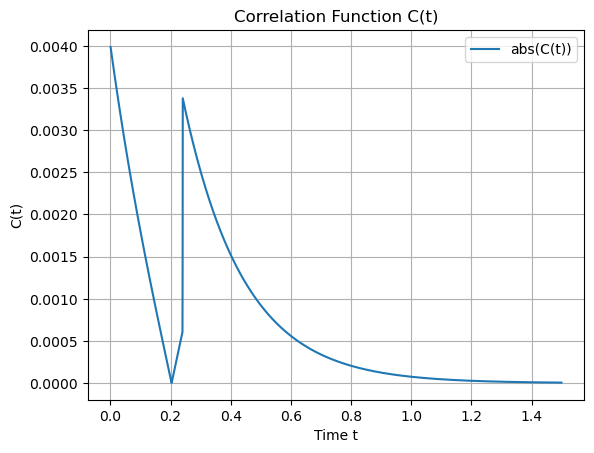

In [45]:
#CorrelationFunction
#Analytical 

# Parameters
dt = 0.0005
time = np.arange(0, tmax, dt)  # Time axis
P_e = np.zeros(len(time), dtype=complex)  # Probability of excited state
P_e[0] = 1.0  # Initial condition
def sinhint(x):
    sinh_integral, _ = shichi(np.float64(x))  # shichi returns (sinhint, coshint)
    return sinh_integral

def coshint(x):
    _,cosh_integral = shichi(np.float64(x))  # shichi returns (sinhint, coshint)
    return cosh_integral # Simplified placeholder for CoshIntegral

def C(t):
    if t >= 0:
        return (1 / np.pi) * gamma * lam * (
            -2j * np.exp(-t * gamma) * np.pi +
            (np.exp(-t * gamma) + np.exp(t * gamma)) * coshint(t * gamma) +
            np.sqrt(np.pi) * meijerg([[0], []], [[0, 0], [1/2]], (t**2 * gamma**2) / 4) -
            1j * np.exp(-gamma * np.abs(t - Td)) * np.pi * np.sign(t - Td) -
            1j * np.exp(-(t + Td) * gamma) * np.pi * np.sign(t + Td) +
            np.exp(-t * gamma) * sinhint(t * gamma) -
            np.exp(t * gamma) * sinhint(t * gamma)
        )
    else:
        return 0.0
    
# Only Int J(w)*i*sin() 
def C_imag_analytisch(t):
    return -0.5*1j*gamma*lam*(2*np.cosh(t*gamma)*(1 + np.cosh(Td*gamma)) + np.cosh((t - Td)*gamma)*(np.floor((np.pi - 2*np.angle(t - Td))/(4.*np.pi)) - np.floor(0.75 + np.angle(t - Td)/(2.*np.pi)))) if t >= 0 else 0
# Diskretisiere die Korrelationsfunktion
C_imag_A = np.array([C_imag_analytisch(t) for t in time])

# Apply C(t) to each element of the time array using a list comprehension
C_vals = np.array([C(t) for t in time]) #. 
C_vals_imag = np.array([C(t).imag for t in time])
C_vals_real = np.array([C(t).real for t in time])
# Plot the results
#plt.plot(time, (C_vals), label="abs(C(t))")
plt.plot(time, np.abs(C_vals) , label="abs(C(t))")
plt.xlabel("Time t")
plt.ylabel("C(t)")
plt.title("Correlation Function C(t)")
plt.legend()
plt.grid(True)
plt.show()



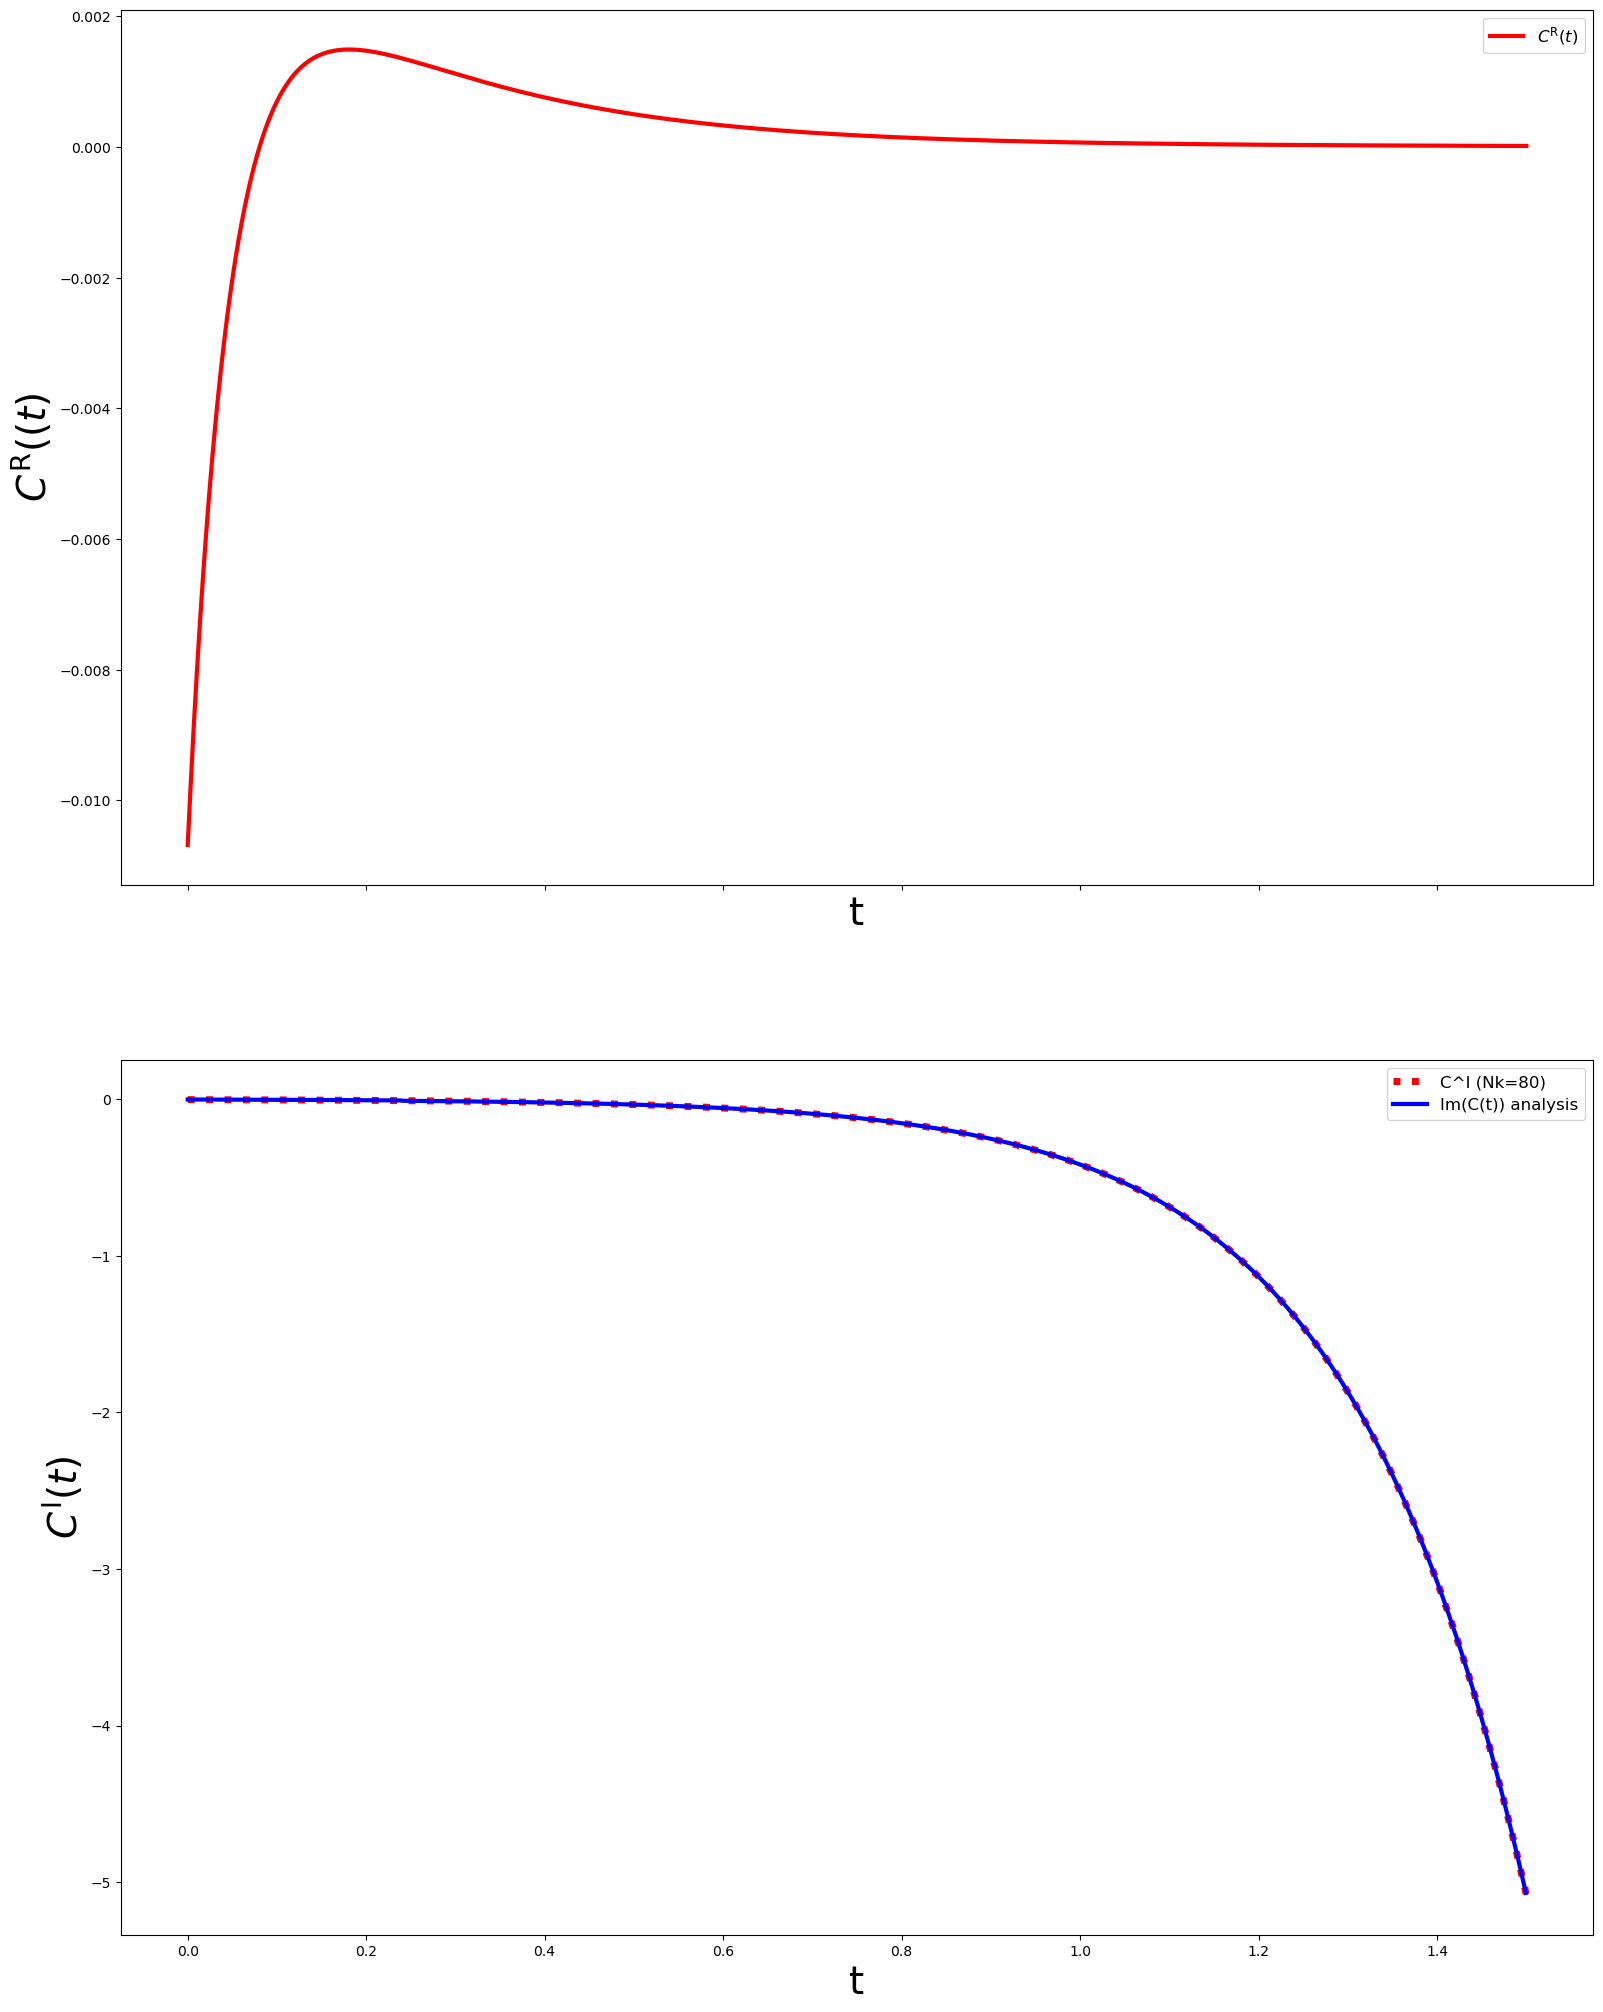

In [46]:
#Matsubara decomposittion reverser 

#From qutip
def CR(bath, t):
    result = 0
    for exp in bath.exponents:
        if exp.type == BathExponent.types['R'] or exp.type == BathExponent.types['RI']:
            result += exp.ck * np.exp(-exp.vk * t)
    return result

def CI(bath, t):
    result = 0
    for exp in bath.exponents:
        if exp.type == BathExponent.types['I']:
            result += exp.ck * np.exp(exp.vk * t)
        if exp.type == BathExponent.types['RI']:
            result += exp.ck2 * np.exp(exp.vk * t)
    return result

  
  
#Selfamde decomposition reverser
def C_real(ck_real, vk_real, tlist):
    ck_real = np.array(ck_real, dtype=np.complex128)
    vk_real = np.array(vk_real, dtype=np.complex128)
    tlist = np.array(tlist, dtype=np.complex128)
    # Summiere über alle k
    C_R = np.sum([c * np.exp(-v * tlist) for c, v in zip(ck_real, vk_real)], axis=0)
    return C_R


def C_imag(ck_imag, vk_imag, tlist):
    # Konvertiere Eingaben in NumPy-Arrays
    ck_imag = np.array(ck_imag, dtype=np.complex128)
    vk_imag = np.array(vk_imag, dtype=np.complex128)
    
    # Summiere über alle k
    C_I = np.sum([c * np.exp(-v * tlist) for c, v in zip(ck_imag, vk_imag)], axis=0)
    return C_I

# Korrelationsfunktion berechnen
# Korrelationsfunktion IE
C_I_vals = C_imag(ck_imag, vk_imag, tlist)
# Korrelationsfunktion RE
C_R_vals = C_real(ck_real, vk_real, tlist)
#Analytics : funktionen von oben:
C_imag_A = np.array([C_imag_analytisch(t) for t in time])

# Apply C(t) to each element of the time array using a list comprehension
C_tot_A = np.array([C(t) for t in time]) #. 



fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(19, 25), sharex=True)
#ax1.plot(tlist, CR(Bad, tlist), "g", linewidth=2, label=f"C^R (Nk={Nk})")#This line of code is plotting the values of the variable `C_R_vals` against the values in the `tlist` array on the graph represented by `ax1`. The label for this plot is set as "^\mathrm{R}(t)$" which will be displayed on the legend of the plot. The color of the plot is set to blue with a linewidth of 2.

ax1.plot(tlist, (C_R_vals), label=r"$C^\mathrm{R}(t)$", color="r", linewidth=3,linestyle='-')

#ax1.plot(time, np.abs(C_tot_A), label="|(C(t))| analysis", color="blue", linewidth=2)


ax2.plot(tlist, -np.abs(CI(Bad, tlist)), "r", linewidth=5,linestyle='dotted' ,label=f"C^I (Nk={Nk})")
ax2.plot(time, np.imag(C_imag_A), label="Im(C(t)) analysis", color="blue", linewidth=3)
#ax2.plot(tlist, (CI(Bad, tlist)+CR(Bad,tlist)), "r", linewidth=5,linestyle='-' ,label=f"C^I (Nk={Nk})")
ax1.set_xlabel(r't', fontsize=28)
ax1.set_ylabel(r"$C^\mathrm{R}((t)$", fontsize=28)
ax1.legend(loc=0, fontsize=12)
ax2.set_xlabel(r't', fontsize=28)
ax2.set_ylabel(r"$C^\mathrm{I}(t)$", fontsize=28)
ax2.legend(loc=0, fontsize=12)

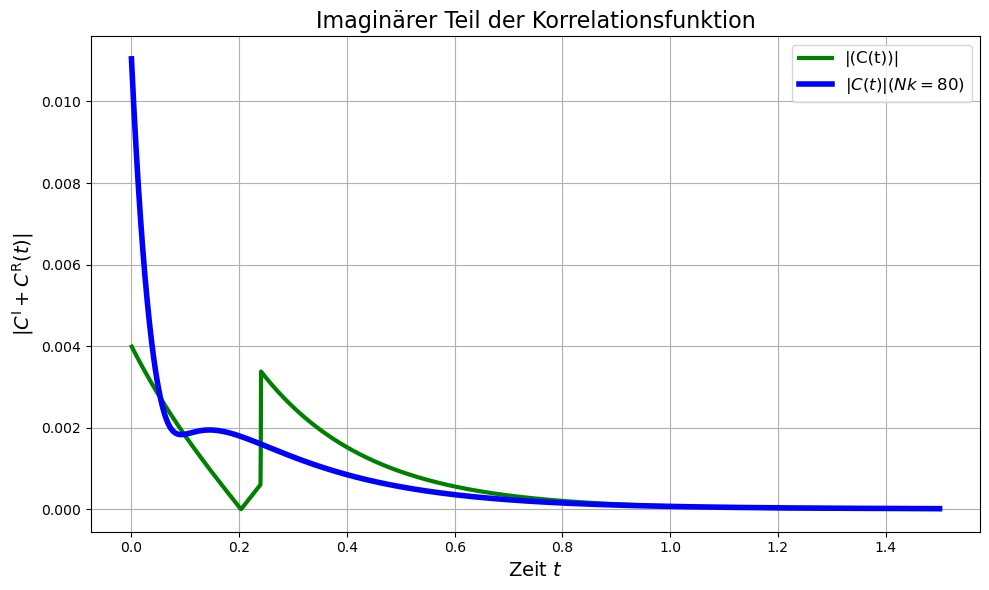

In [47]:
import numpy as np
import matplotlib.pyplot as plt

BeideC=(C_R_vals+C_I_vals)
# Plot
plt.figure(figsize=(10, 6))
#plt.plot(tlist, CI(Bad, tlist), "g", linewidth=6,linestyle='dotted' ,label=f"C^I (Nk={Nk})")
#plt.plot(tlist, C_I_vals, label=r"$C^\mathrm{I}(t)$", color="red", linewidth=2)
#plt.plot(tlist, C_R_vals, label=r"$C^\mathrm{R}(t)$", color="red", linewidth=2)


plt.plot(time, np.abs(C_tot_A), linestyle='-', linewidth=3, color='g' ,label="|(C(t))|")

#plt.plot(tlist, (BeideC), label=f"$C(t) (Nk={Nk})$", color="blue", linewidth=4,linestyle=':')
plt.plot(tlist, np.abs(BeideC), label=f"$|C(t) |(Nk={Nk})$", color="blue", linewidth=4,linestyle='-')
plt.xlabel("Zeit $t$", fontsize=14)
plt.ylabel(r"$|C^\mathrm{I}+C^\mathrm{R}(t)|$", fontsize=14)
plt.title("Imaginärer Teil der Korrelationsfunktion", fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()